In [1]:
## Import
import numpy as np
import pandas as pd
## Load MNIST dataset
train_df = pd.read_csv('./mnist_train.csv')
train_df_array = train_df.values
# train_df.head()
test_df = pd.read_csv('./mnist_test.csv')
test_df_array = test_df.values
test_df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
# Create train and test arrays
X_train = train_df_array[:, 1:]
y_train = train_df_array[:, 0]
X_test = test_df_array[:, 1:]
y_test = test_df_array[:, 0]

# Normalize
def normalize(X):
    # X has the shape (examples * dimension)
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)+1e-100
    return (X-mean)/std, mean, std

X_train, train_mean, train_std = normalize(X_train)
X_test, test_mean, test_std = normalize(X_test)
print(X_train.shape, y_train.shape)

(60000, 784) (60000,)


In [3]:
# Split the dataset into small batches (due to slow PLCA updates)
def K_duplicates(y, K):
    counts=[0 for k in range(10)]
    indices=[]
    for i in range(len(y)):
        if counts[y[i]]>=K : continue
        indices.append(i)
        counts[y[i]]+=1
    # print(counts)
    return indices

indices = K_duplicates(y_train, 100)
train_batch = X_train[indices, :].T
print(train_batch.shape)
corresponding_digits = y_train[indices]
print(corresponding_digits.shape)

(784, 1000)
(1000,)


In [4]:
## PLCA Initialize
def initialize(X, Y, Z):
    Px_z = np.random.uniform(low=0.1, high=0.9, size=(X, Z))
    Px_zbyy = np.random.uniform(low=0.1, high=0.9, size=(X, Y, Z))
    P_ybyz = np.random.uniform(low=0.1, high=0.9, size=(Z, Y))
    return Px_z, Px_zbyy, P_ybyz

## PLCA Normalize
def normalize_Px_z(X, Px_z) :
    for x in range(X): 
        Px_z[x, :] = Px_z[x, :]/sum(Px_z[x, :])
    return Px_z

def normalize_P_ybyz(Z, P_ybyz) :
    for z in range(Z): 
        P_ybyz[z, :] = P_ybyz[z, :]/sum(P_ybyz[z, :])
    return P_ybyz

def normalize_Px_zbyy(X, Y, Px_zbyy) :
    for x in range(X):
        for y in range(Y):
            Px_zbyy[x, y, :] = Px_zbyy[x, y, :]/sum(Px_zbyy[x, y, :])
    return Px_zbyy

In [5]:
## PLCA Update
def update_Px_zbyy(X, Z, Y, Px_zbyy, Px_z, P_ybyz) :
    for x in range(X):
        for y in range(Y):
            for z in range(Z):
                Px_zbyy[x, y, z] = Px_z[x, z]*P_ybyz[z, y]/np.dot(Px_z[x, :], P_ybyz[:, y])
    return Px_zbyy

def update_Px_z(X, Z, Px_z, Px_zbyy, Ixy) :
    for x in range(X):
        for z in range(Z):
            denominator=0
            for z1 in range(Z):
                if z1==z : numerator = np.dot(Ixy[:, x], Px_zbyy[x, :, z])
                denominator += np.dot(Ixy[:, x], Px_zbyy[x, :, z1])
            if(denominator) : Px_z[x, z] = numerator/denominator
            else : Px_z[x, z]=0
    return Px_z

def update_P_ybyz(Z, Y, P_ybyz, Px_zbyy, Ixy) :
    for z in range(Z):
        for y in range(Y):
            denominator=0
            for y1 in range(Y):
                if y1==y : numerator =  np.dot(Ixy[y, :], Px_zbyy[:, y, z])
                denominator += np.dot(Ixy[y1, :], Px_zbyy[:, y1, z])
            if(denominator) : P_ybyz[z, y] = numerator/denominator
            else :  P_ybyz[z, y]=0
    return P_ybyz

def update_all(Ixy, iterations=1000, threshold=1e-3) :
    X = Ixy.shape[1]
    Y = Ixy.shape[0]
    Z = 3    
    # initialize and normalize
    Px_z, Px_zbyy, P_ybyz = initialize(X, Y, Z)
    Px_z = normalize_Px_z(X, Px_z)
    P_ybyz = normalize_P_ybyz(Z, P_ybyz)
    Px_zbyy = normalize_Px_zbyy(X, Y, Px_zbyy)
    # iterative updates
    for iteration in range(iterations) :
        initial_Px_z = Px_z
        initial_P_ybyz = P_ybyz
        initial_Px_zbyy = Px_zbyy
        # update
        updated_Px_zbyy = update_Px_zbyy(X, Z, Y, Px_zbyy, Px_z, P_ybyz)
        updated_Px_z = update_Px_z(X, Z, Px_z, Px_zbyy, Ixy)
        updated_P_ybyz = update_P_ybyz(Z, Y, P_ybyz, Px_zbyy, Ixy)
        # compare
        if np.all(abs(updated_Px_zbyy-initial_Px_zbyy))>threshold : continue
        elif np.all(abs(updated_Px_z-initial_Px_z))>threshold : continue
        elif np.all(abs(updated_P_ybyz-initial_P_ybyz))>threshold : continue
        else : break
    return Px_z, Px_zbyy, P_ybyz

In [6]:
# Train
Px_z, Px_zbyy, P_ybyz = update_all(train_batch, 10, 1e-2)
print(Px_z.shape, P_ybyz.shape)
print(corresponding_digits.shape)

(1000, 3) (3, 784)
(1000,)


In [7]:
# Plot the low dimensional representations
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
figure = plt.figure()
axes = Axes3D(figure)
for digit in np.unique(corresponding_digits):
    index = np.where(corresponding_digits == digit)
    axes.scatter(Px_z[index][0], Px_z[index][1], Px_z[index][2], label=digit, s=20)
axes.legend()
plt.show()

<Figure size 640x480 with 1 Axes>

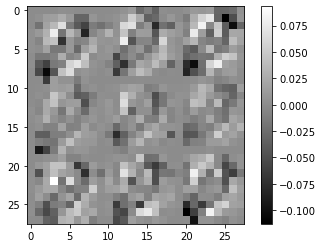

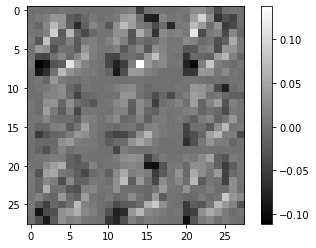

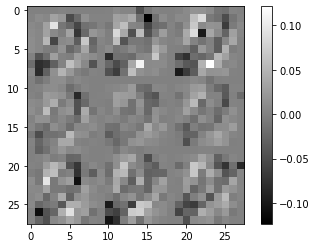

In [8]:
# Plot the basis vectors as images
sq_dim = int(np.sqrt(P_ybyz.shape[1]))
channels = P_ybyz.shape[0]
reshaped_basis = np.reshape(P_ybyz, (sq_dim, sq_dim, channels))
for k in range(P_ybyz.shape[0]):
    plt.imshow(reshaped_basis[:, :, k], cmap='gray')
    plt.colorbar()
    plt.show()

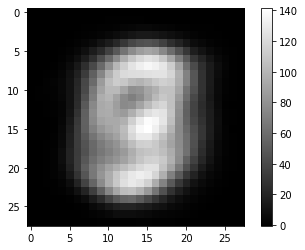

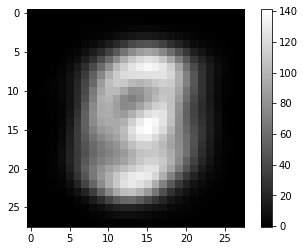

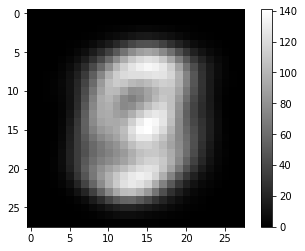

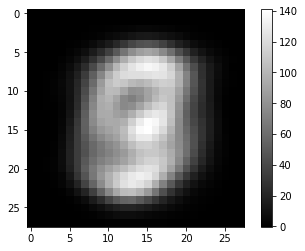

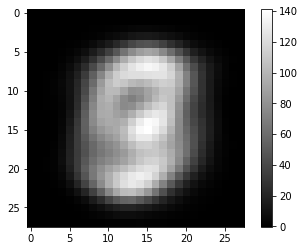

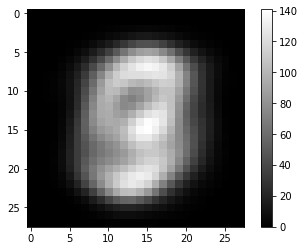

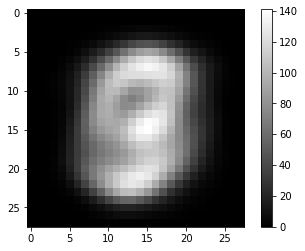

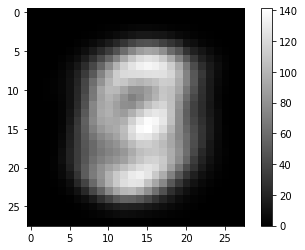

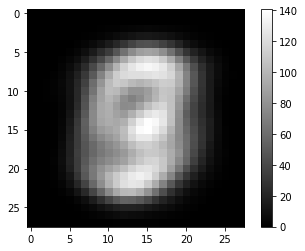

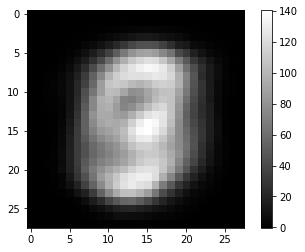

In [9]:
# Plot the reconstructed samples, one per image
indices = K_duplicates(corresponding_digits, 1)
for index in indices:
    Px_z_index = np.reshape(Px_z[index], [1]+list(Px_z[index].shape))
    reconstructed_vector = np.dot(Px_z_index, P_ybyz)
    unnormalized_vector = reconstructed_vector*(train_std+1e-100) + train_mean
    side_length = int(np.sqrt(P_ybyz.shape[1]))
    reconstructed_array = np.reshape(unnormalized_vector, (side_length, side_length))
    plt.imshow(reconstructed_array, cmap='gray')
    plt.colorbar()
    plt.show()   